# 1. 패키지 임포트 및 설정

In [1]:
# 기타
import os

# 전처리 관련 패키지
import numpy as np
import pandas as pd
import pandas_profiling
import missingno as msno

# 시각화 패키지
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

if os.name == 'nt':
    mpl.rc('font', family = 'binggrae')
elif os.name == 'posix':
    mpl.rc('font', family = 'AppleGothic')
else:
    print('check your os')

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# mpl.rc('font', family='binggrae')
mpl.rc('axes', unicode_minus=True)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10000

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드 및 전처리
- 테이블 변수명
    - df_oxi : Oxidation csv table
    - df_soft : Photo softback csv table
    - df_litho : Photo lithography csv table
    - df_etch : Etching csv table
    - df_imp : Ion implantation csv table
    - df_ins : Inspection csv table
    

> 각 테이블의 이상치나 결측치는 NaN으로 처리하고 최종 병합 후 drop

## 2.0 이상치 제거 함수 정의
- 모든 데이터 테이블에 적용한다

In [2]:
# 사분위수를 이용해서 이상치를 제거
# 제거 함수 정의
def remove_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # print(q1, q3, lower_bound, upper_bound)
    
    mask = np.where((data<=upper_bound) & (data>=lower_bound), data, np.NaN)
    return mask

- **np.percentile() ?**

```python
np.percentile()

#주요인자
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Percentile or sequence of percentiles to compute, which must be between
    0 and 100 inclusive.
```

In [3]:
# 데이터 path
path = '../data/project1/'

## 2.1 Oxidation Data

In [4]:
# 산화 공정 데이터 테이블 Read
df_oxi = pd.read_csv(path+'Oxid.csv')
df_oxi.head(3)

,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62,699.443,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137,696.792,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,1,Oxidation,dry,1062.467808,O2,39.51,0.217,128,705.471,NOLSM313,1,3,17-02-2019 PM 9:04:30


### 결측치 파악 

<Figure size 576x360 with 0 Axes>

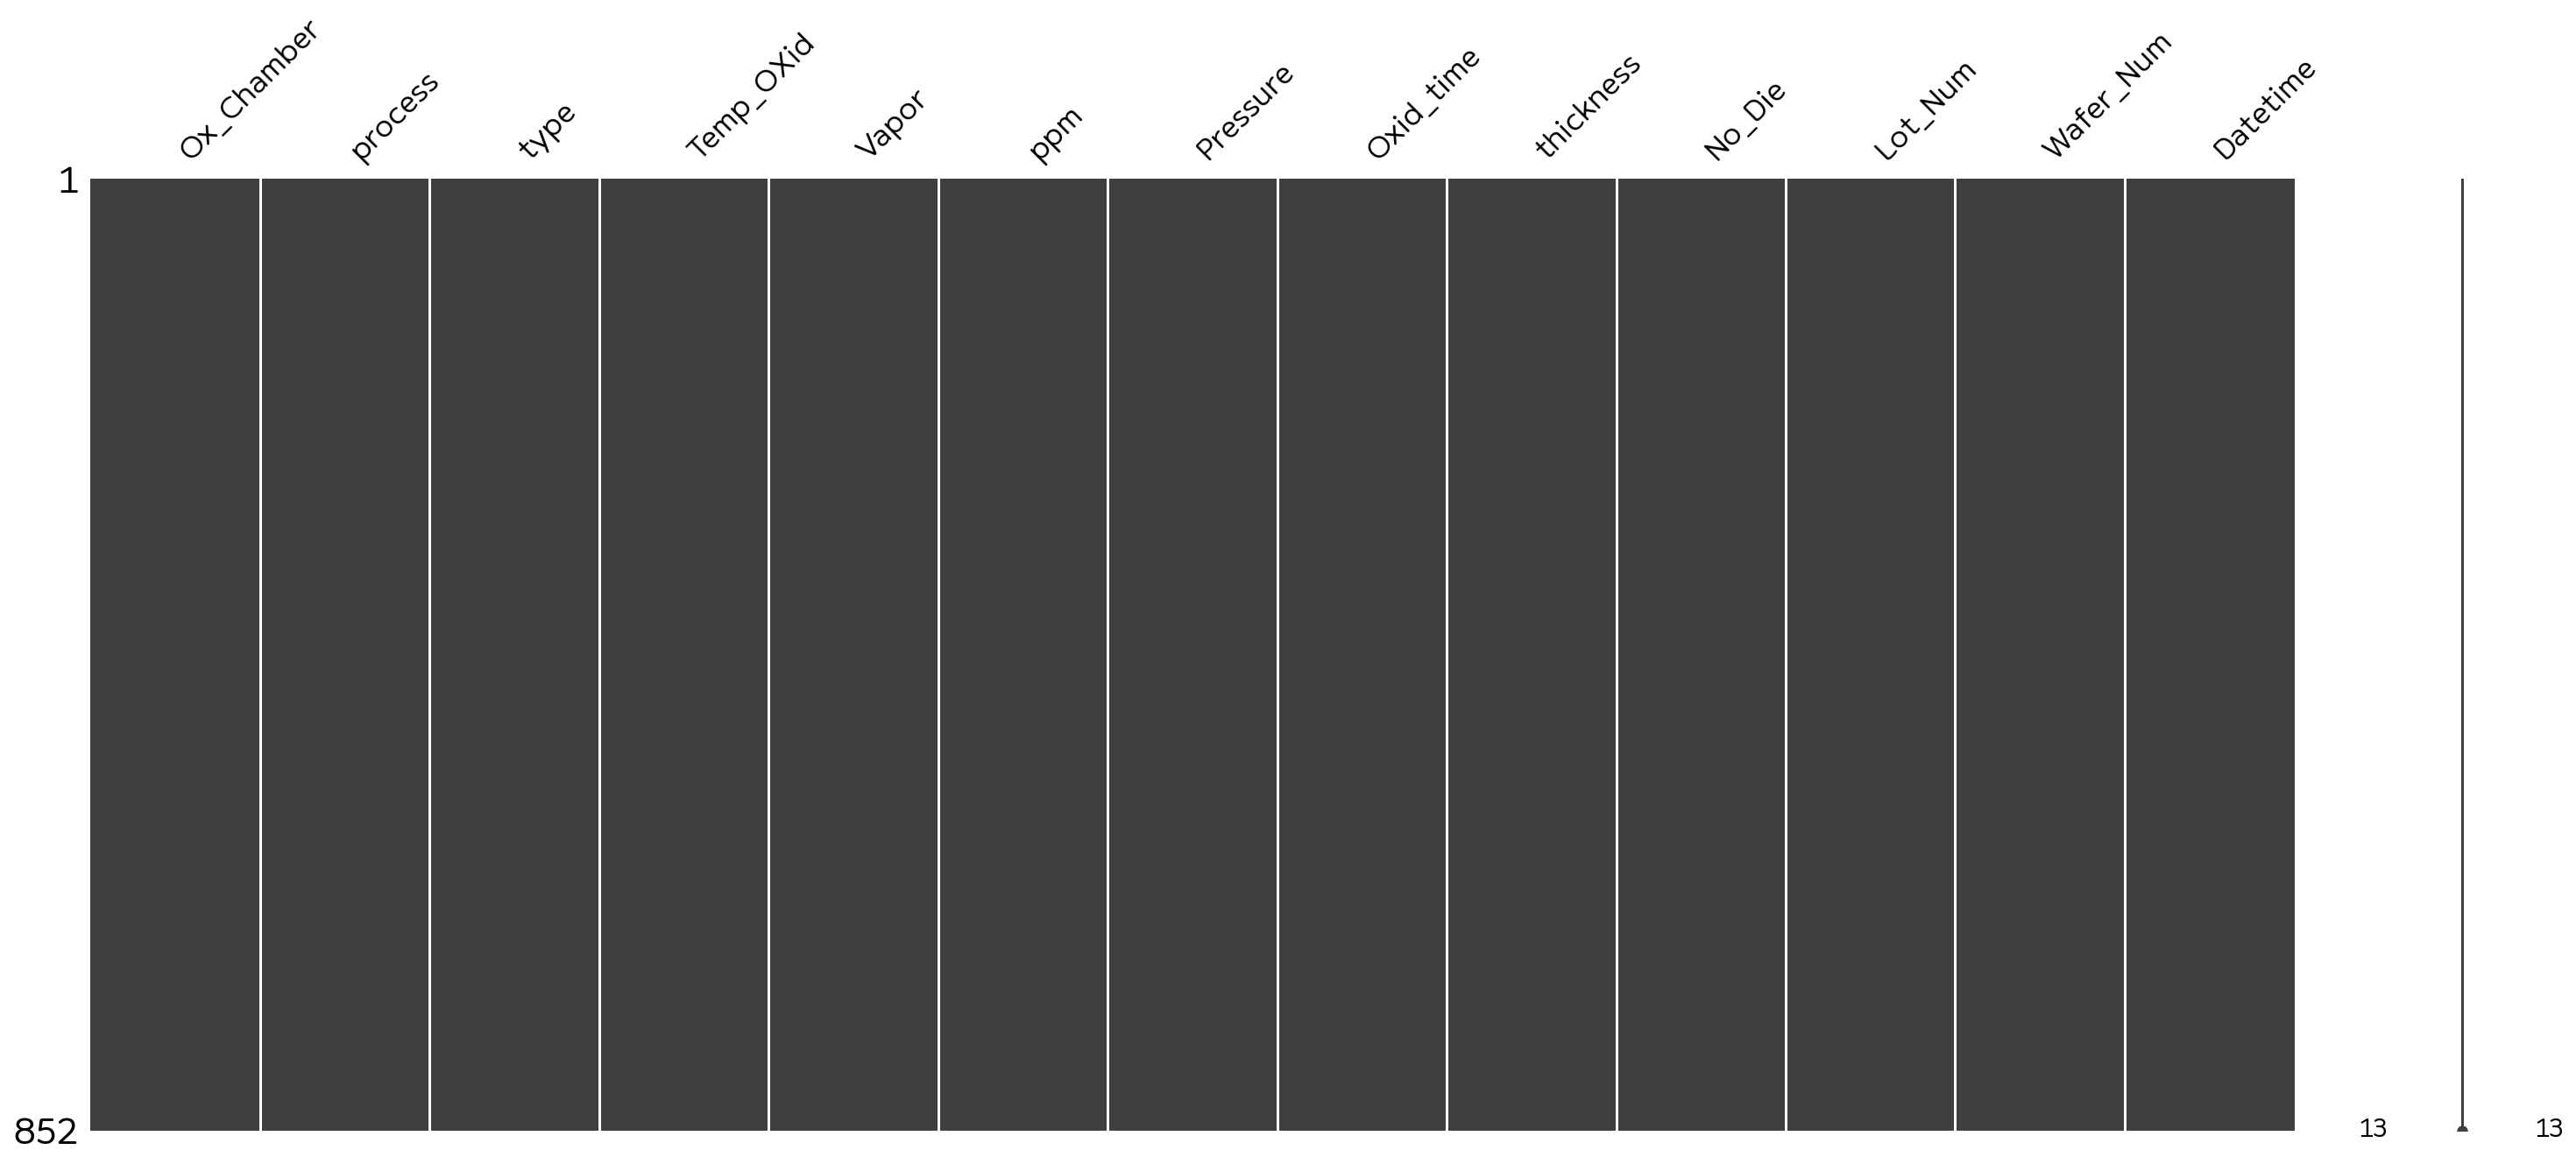

In [5]:
plt.figure(figsize=(8,5))
msno.matrix(df_oxi)
plt.show()
# 결측치는 없다.

### 이상치 파악 및 제거

In [6]:
# 컬럼 확인
print(np.array(df_oxi.columns))

['Ox_Chamber' 'process' 'type' 'Temp_OXid' 'Vapor' 'ppm' 'Pressure'
 'Oxid_time' 'thickness' 'No_Die' 'Lot_Num' 'Wafer_Num' 'Datetime']


In [7]:
df_oxi.describe()
# 연속형 변수는 Ox_Chamber, Temp_OXid, ppm, Pressure, Oxid_time, thickness, Lot_Num, Wafer_Num

,Ox_Chamber,Temp_OXid,ppm,Pressure,Oxid_time,thickness,Lot_Num,Wafer_Num
count,852.00000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
mean,2.00000,1064.415784,33.202242,0.211374,123.201878,710.926810,16.281690,13.894366
std,0.81265,149.550147,8.494070,0.009067,76.285130,8.082856,9.116841,7.785951
min,1.00000,862.011276,21.070000,0.180000,-6.000000,681.435000,1.000000,1.000000
25%,1.00000,874.756813,22.450000,0.205000,52.000000,706.313000,8.000000,7.000000
50%,2.00000,1069.240209,33.420000,0.213000,116.000000,711.590500,16.000000,14.000000
75%,3.00000,1189.172249,40.452500,0.217000,217.000000,715.595000,24.000000,21.000000
max,3.00000,1339.476675,49.910000,0.229000,291.000000,737.402000,32.000000,27.000000


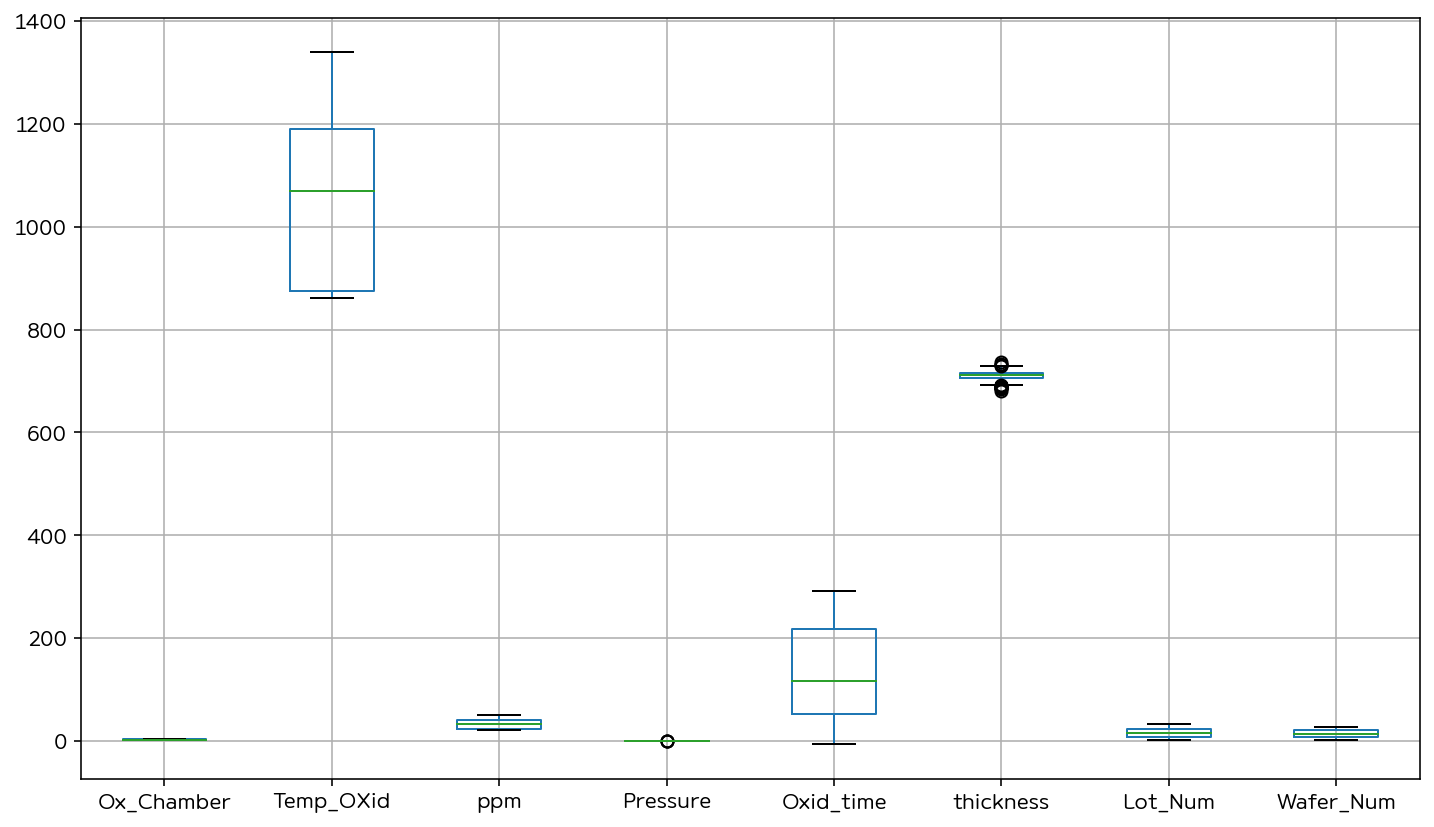

In [8]:
df_oxi.boxplot(figsize=(12,7))
plt.show()

In [9]:
# 아웃라이어 제거
continuous_ls = ['Ox_Chamber', 'Temp_OXid', 'ppm', 'Pressure', 'Oxid_time', 'thickness', 'Lot_Num', 'Wafer_Num']
for val in continuous_ls:
    df_oxi[val] = df_oxi[val].apply(remove_outlier)

In [10]:
# 시간이 0이하를 제거
df_oxi['Oxid_time'] = np.where(df_oxi['Oxid_time'] <= 0 , np.nan, df_oxi['Oxid_time'])

# thickness가 이론적으로 700nm 이상이 되야 다음 공정이 원할히 진행될 수 있음.
# 700이상은 두고 미만은 제거할 예정
# 700이상의 데이터를 Reinforcement 컬럼을 추가해 True, False 값 추가
df_oxi['Reinforcement'] = np.where(df_oxi['thickness'] >= 700., True, False)
df_oxi.head(3)

,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,No_Die,Lot_Num,Wafer_Num,Datetime,Reinforcement
0,1.0,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,False
1,1.0,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,False
2,1.0,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,True


In [11]:
# 정상 wafer와 700nm 이하 wafer에 대해, oxidation 연속형 변수에 대해서 평균값 확인
df_oxi.pivot_table(index='Reinforcement', values=['Oxid_time', 'Pressure', 'Temp_OXid', 'ppm'])

# 차후 통계적 가설 검증을 통해, 산화막 증착 시간이 박막 두께에 대해 유의미한 차이가 있는지 확인

,Oxid_time,Pressure,Temp_OXid,ppm
Reinforcement,,,,
False,111.448718,0.206524,1082.455629,34.090732
True,125.555411,0.211891,1062.494658,33.107623


## 2.2 Softbake Data

In [12]:
df_soft = pd.read_csv(path+'Photo_Softbake.csv')
df_soft.drop('Unnamed: 0', axis=1, inplace=True)
df_soft.head()

,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,1,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,1,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,NOLSM313,1,3,17-02-2019 PM 9:04:30
3,2,Photo,0.882195,16.368,14.944,19.998,199.649,90.001,505.249,3922.191,5131.972,5.069,91.881,29.997,NOLSM414,1,4,17-02-2019 PM 9:04:30
4,2,Photo,0.834001,13.926,14.933,20.002,204.544,90.001,501.089,4124.099,5108.355,5.055,91.212,30.001,NOLSM515,1,5,17-02-2019 PM 9:04:30


### 이상치 제거

In [13]:
# 연속형 변수의 컬럼명만 추출
continuous_ls = list(df_soft.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_soft[val] = df_soft[val].apply(remove_outlier)

## 2.3 Lithography Data

In [14]:
df_litho = pd.read_csv(path+'Photo_lithography.csv')
df_litho.head(3)

,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,No_Die,Lot_Num,Wafer_Num,Datetime
0,1,30.959,Hg-Arc,H,405,516.657,109.769,NOLSM111,1,1,17-02-2019 PM 9:04:30
1,2,29.653,Hg-Arc,H,405,501.894,107.102,NOLSM212,1,2,17-02-2019 PM 9:04:30
2,3,28.063,Hg-Arc,I,365,506.750,110.471,NOLSM313,1,3,17-02-2019 PM 9:04:30


### 이상치 제거

In [15]:
continuous_ls = list(df_litho.select_dtypes(exclude = 'object').columns)
for val in continuous_ls:
    df_litho[val] = df_litho[val].apply(remove_outlier)

### Line Critical Dimension으로 나누기
- 리소그래피의 결과로 그려진 웨이퍼의 line pattern 간의 거리로 적정값이 25~55nm 사이다.

In [16]:
df_litho['Range_check'] = np.where((df_litho['Line_CD'] >=25) & (df_litho['Line_CD'] <= 55), True, False)
df_litho.head(3)

,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,No_Die,Lot_Num,Wafer_Num,Datetime,Range_check
0,1.0,30.959,Hg-Arc,H,405.0,516.657,109.769,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,True
1,2.0,29.653,Hg-Arc,H,405.0,501.894,107.102,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,True
2,3.0,28.063,Hg-Arc,I,365.0,506.750,110.471,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,True


In [17]:
pd.crosstab(index=df_litho['Range_check'], columns=df_litho['UV_type'])
# H Type beam에서 False값이 높다.
# 추후 통계적 가설검정을 통해 해당 공정에 대한 out of range 확인 예정

UV_type,G,H,I
Range_check,,,
False,45,94,48
True,267,192,206


## 2.4 Etching Data

In [18]:
df_etch = pd.read_csv(path+'Etching.csv')
df_etch.drop('Unnamed: 0', axis=1, inplace=True)
df_etch.head(3)

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num,Wafer_Num,Datetime,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1
0,3,Etching,70.878,50.851,1.047,NOLSM111,1,1,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38
1,2,Etching,69.561,52.283,1.051,NOLSM212,1,2,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11
2,1,Etching,70.968,51.610,1.017,NOLSM313,1,3,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80


In [19]:
print(df_etch.shape)
df_etch.describe()

(852, 13)


,Etching_Chamber,Temp_Etching,Source_Power,Selectivity,Lot_Num,Wafer_Num,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,851.000000,851.000000,851.000000,851.000000
mean,1.967136,71.147822,51.227459,1.032140,16.281690,13.894366,296.633373,311.276439,347.799401,404.940012
std,0.830584,0.824158,0.634215,0.016238,9.116841,7.785951,125.378446,125.714630,125.774630,125.790535
min,1.000000,68.150000,49.342000,0.984000,1.000000,1.000000,-49.000000,-34.650000,2.000000,59.380000
25%,1.000000,70.709750,50.794500,1.022000,8.000000,7.000000,202.000000,216.525000,252.880000,310.185000
50%,2.000000,71.220500,51.247000,1.033500,16.000000,14.000000,281.000000,295.970000,332.480000,389.630000
75%,3.000000,71.656500,51.698250,1.043000,24.000000,21.000000,372.000000,386.675000,423.050000,480.355000
max,3.000000,73.081000,53.272000,1.076000,32.000000,27.000000,687.000000,700.240000,736.510000,793.500000


### 이상치제거

In [20]:
continuous_ls = list(df_etch.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_etch[val] = df_etch[val].apply(remove_outlier)

### Etching 공정 데이터에서 Thin Film 값이 150nm 이하로 떨어지는 값을 제거
- Thin Film이 150nm 이상이 되어야 다음 공정이 가능하다고 한다.

In [22]:
for i in range(1,5):
    df_etch[f'Thin Film {i}'] = np.where(df_etch[f'Thin Film {i}']<150, np.NaN, df_etch[f'Thin Film {i}'])

### Etching Rate
- 식각공정 중 표면에 material이 제거되는 속도
- 추후 etching rate가 품지에 영향을 얼마나 미치는지 확인할 예정

$$ ER = \frac{thin1 - thin4}{30} $$

In [23]:
df_etch['ER'] = (df_etch['Thin Film 1'].round(3) - df_etch['Thin Film 4'].round(3)) / 30
df_etch.head(3)

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num,Wafer_Num,Datetime,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER
0,3.0,Etching,70.878,50.851,1.047,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38,3.679333
1,2.0,Etching,69.561,52.283,1.051,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11,3.637000
2,1.0,Etching,70.968,51.610,1.017,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80,3.560000


## 2.5 Implantation

In [24]:
df_imp = pd.read_csv(path+'Implant.csv')
df_imp.head(3)

,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,No_Die,Lot_Num,Wafer_Num,Datetime
0,3,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,0.01,102.847,885.0,154,NOLSM111,1,1,17-02-2019 ?? 9:04:30
1,2,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,0.01,104.323,919.0,154,NOLSM212,1,2,17-02-2019 ?? 9:04:30
2,1,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,0.01,100.605,916.0,155,NOLSM313,1,3,17-02-2019 ?? 9:04:30


In [25]:
df_imp.describe()
# 음수값이 나오는 컬럼은 Flux90s, Flux160s임

,Chamber_Num,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,Lot_Num,Wafer_Num
count,852.000000,8.510000e+02,8.510000e+02,8.510000e+02,8.520000e+02,8.520000e+02,852.000000,8.520000e+02,852.000000,851.000000,852.000000,852.000000,852.000000
mean,1.967136,1.186913e+16,7.982876e+16,4.483541e+17,3.002006e+17,5.999997e+17,32007.862815,1.000000e-02,103.161261,901.128085,154.696009,16.281690,13.894366
std,0.830584,4.603012e+15,5.478891e+16,3.322530e+17,1.145362e+15,1.080690e+12,588.322496,1.614240e-16,1.654830,18.487803,2.420114,9.116841,7.785951
min,1.000000,1.967326e+15,-4.117940e+16,-6.930960e+16,2.963401e+17,5.999965e+17,29604.262000,1.000000e-02,97.744000,854.000000,148.000000,1.000000,1.000000
25%,1.000000,8.590656e+15,3.081442e+16,1.319423e+17,2.994309e+17,5.999990e+17,31640.161000,1.000000e-02,102.063500,890.000000,153.000000,8.000000,7.000000
50%,2.000000,1.177267e+16,8.132774e+16,4.571101e+17,3.001862e+17,5.999997e+17,32200.488500,1.000000e-02,103.295500,904.000000,155.000000,16.000000,14.000000
75%,3.000000,1.516101e+16,1.209841e+17,6.816896e+17,3.009426e+17,6.000004e+17,32420.668750,1.000000e-02,104.322000,915.000000,156.000000,24.000000,21.000000
max,3.000000,2.403938e+16,2.720974e+17,1.401808e+18,3.036145e+17,6.000025e+17,33675.551000,1.000000e-02,107.376000,944.000000,162.000000,32.000000,27.000000


### 이상치 제거

In [26]:
continuous_ls = list(df_imp.select_dtypes(exclude = 'object').columns)
for val in continuous_ls :
    df_imp[val] = df_imp[val].apply(remove_outlier)

### 음수 값으로 측정되는 이상치 제거

In [27]:
print(np.where(df_imp.select_dtypes(exclude = 'object')['Flux60s'].isnull())[0])
df_imp[df_imp['Flux60s'].isnull()]
# 702번 인덱스의 값엔 NaN이 존재.

[702]


,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,No_Die,Lot_Num,Wafer_Num,Datetime
702,2.0,Implantation,NaN,NaN,NaN,3.002952e+17,5.999998e+17,32437.886,0.01,104.475,NaN,157.0,NOLSM703271,27.0,1.0,23-02-2019 ?? 9:04:30


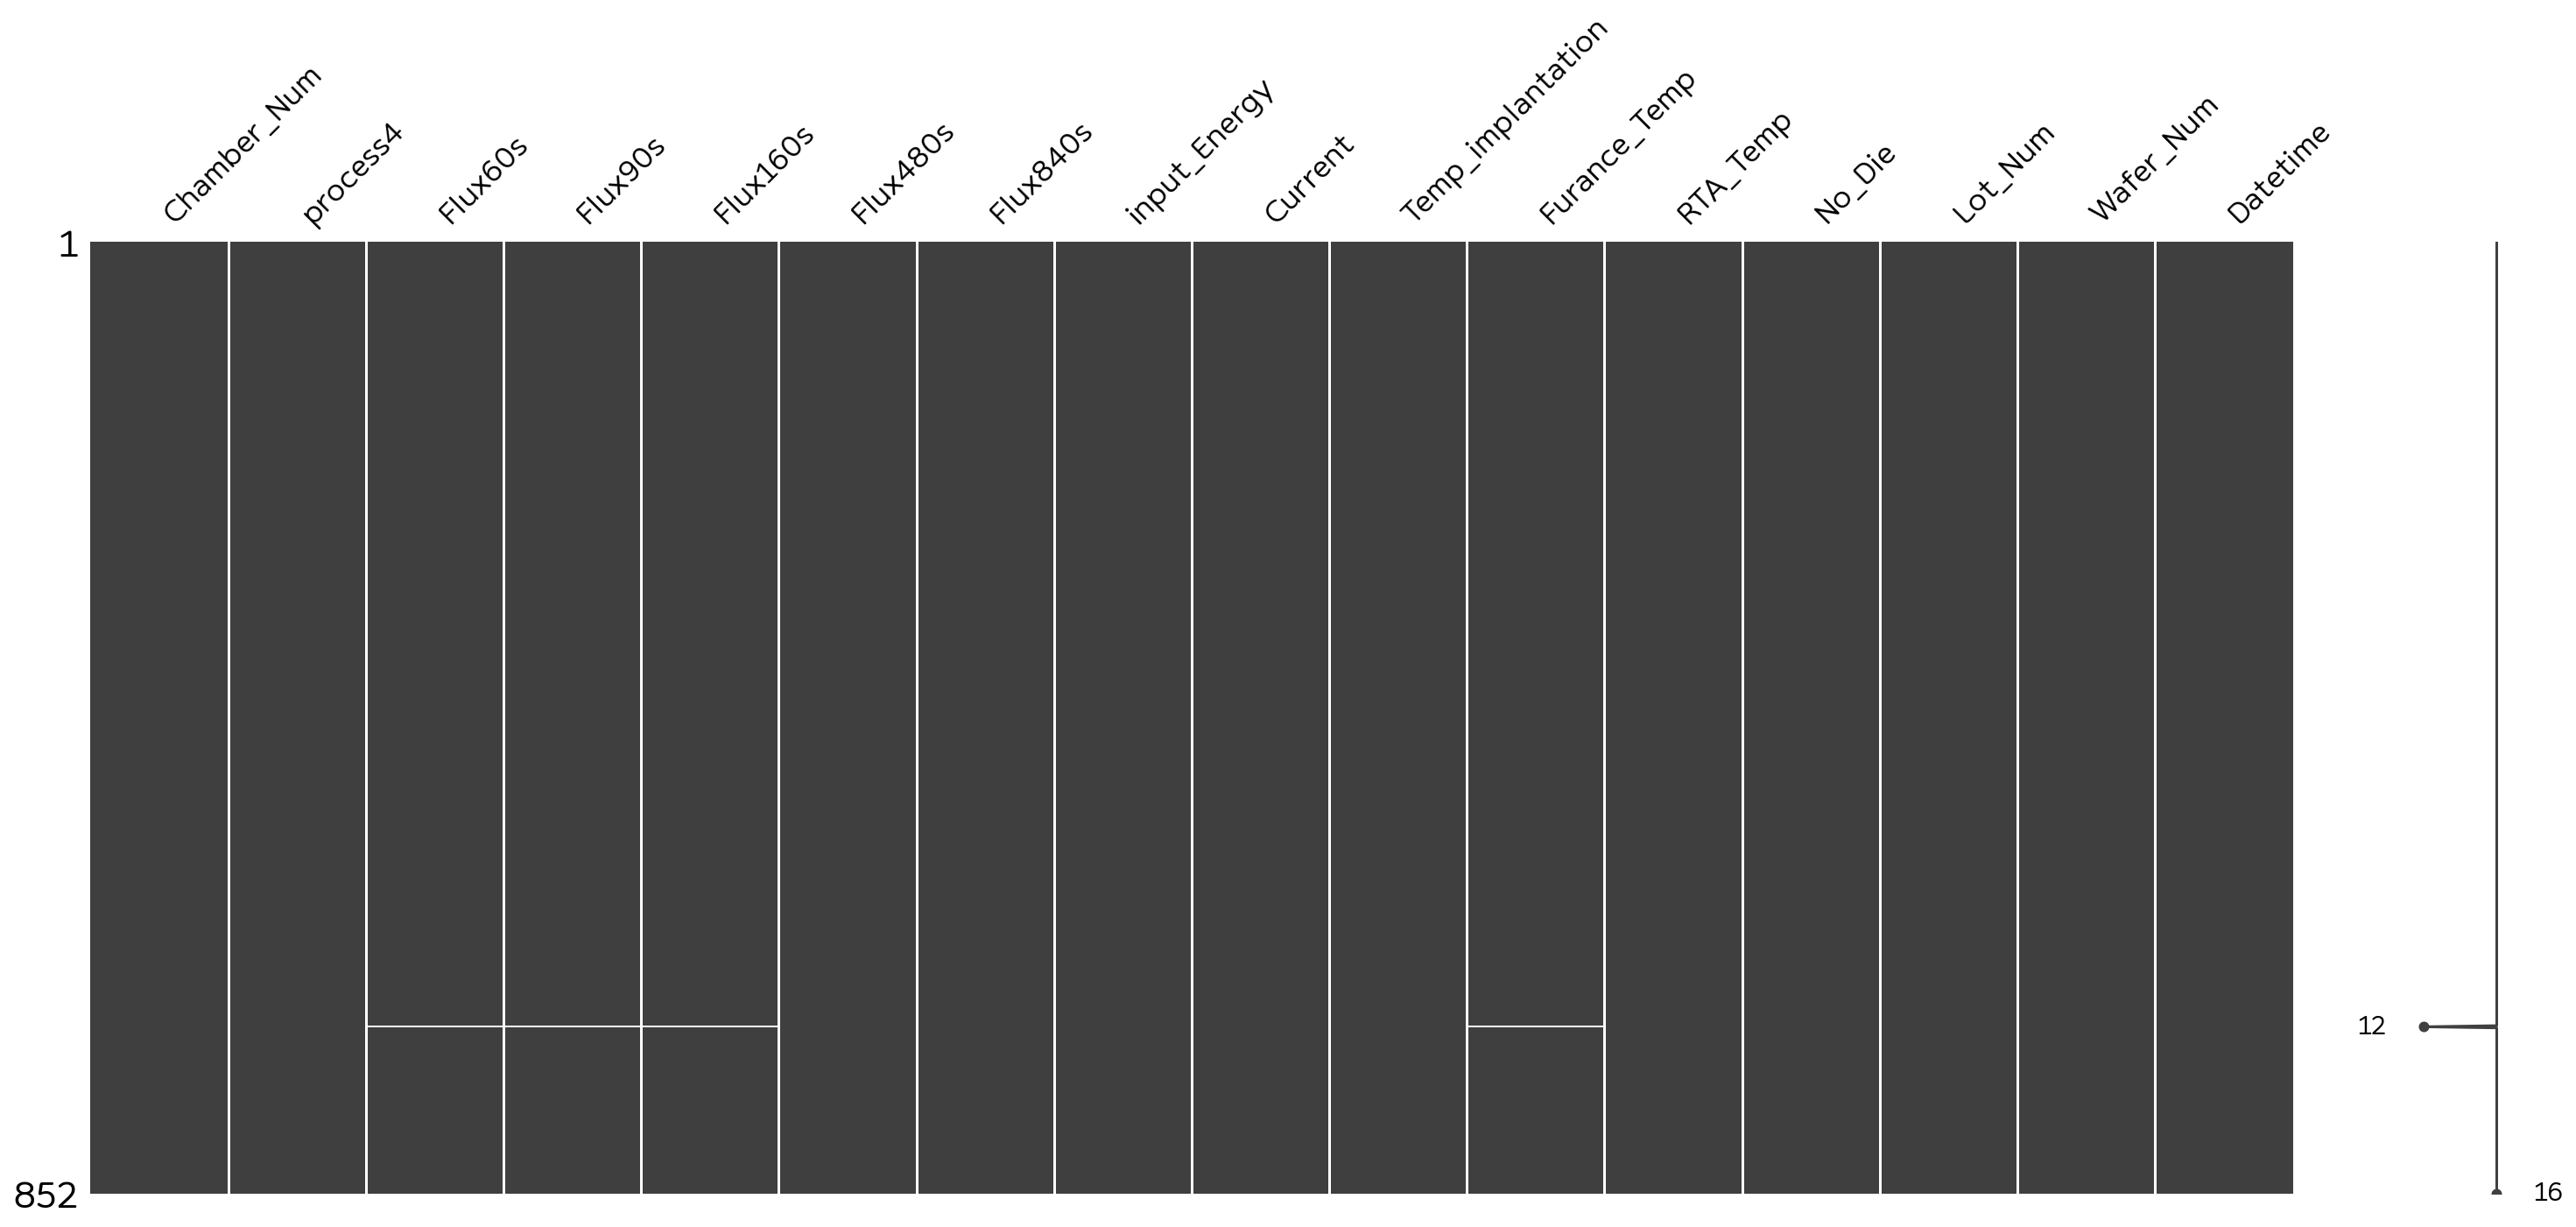

In [28]:
msno.matrix(df_imp)
plt.show()

In [29]:
df_imp['Flux90s'] = np.where(df_imp['Flux90s']<0, np.NaN, df_imp['Flux90s'])
df_imp['Flux160s'] = np.where(df_imp['Flux160s']<0, np.NaN, df_imp['Flux160s'])

## 2.6 Inspection
- 품질 검사에서 발생한 Error 처리
- Error 유무로 새로운 카테고리 값 생성

In [30]:
df_ins = pd.read_csv(path+'Inspect.csv')
df_ins.head()

,Target,No_Die,Lot_Num,Wafer_Num,Datetime,Error_message,Wafer_map
0,96,NOLSM111,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
1,102,NOLSM212,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
2,95,NOLSM313,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
3,117,NOLSM414,1,4,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...
4,143,NOLSM515,1,5,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...


### 에러 메시지가 있으면 1, 없으면 0으로 이산형 변수의 새 컬럼 생성

In [31]:
df_ins['target_binom'] = np.where(df_ins['Error_message']=='none', 0.0, 1.0)
df_ins.head()

,Target,No_Die,Lot_Num,Wafer_Num,Datetime,Error_message,Wafer_map,target_binom
0,96,NOLSM111,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
1,102,NOLSM212,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
2,95,NOLSM313,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
3,117,NOLSM414,1,4,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0
4,143,NOLSM515,1,5,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0


In [32]:
df_ins['target_binom'].value_counts()

0.0    786
1.0     66
Name: target_binom, dtype: int64

# 3. 데이터 병합

### 아래의 각 테이블을 Key : No_Die로 left join
- df_ethc
- df_imp
- df_ins
- df_litho
- df_soft
- df_oxi

In [34]:
df1 = pd.merge(df_etch, df_imp, on='No_Die', how='left')
df1 = pd.merge(df1, df_ins, on='No_Die', how='left')
df1 = pd.merge(df1, df_litho, on='No_Die', how='left')
df1 = pd.merge(df1, df_oxi, on='No_Die', how='left')
df1 = pd.merge(df1, df_soft, on='No_Die', how='left')
df1.head(3)

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num_x,Wafer_Num_x,Datetime_x,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,Lot_Num_y,Wafer_Num_y,Datetime_y,Target,Lot_Num_x,Wafer_Num_x,Datetime_x,Error_message,Wafer_map,target_binom,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,Lot_Num_y,Wafer_Num_y,Datetime_y,Range_check,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Lot_Num_x,Wafer_Num_x,Datetime_x,Reinforcement,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,Lot_Num_y,Wafer_Num_y,Datetime_y
0,3.0,Etching,70.878,50.851,1.047,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38,3.679333,3.0,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,0.01,102.847,885.0,154.0,1.0,1.0,17-02-2019 ?? 9:04:30,96,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,1.0,30.959,Hg-Arc,H,405.0,516.657,109.769,1.0,1.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,1.0,1.0,17-02-2019 PM 9:04:30,False,1.0,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,1.0,1.0,17-02-2019 PM 9:04:30
1,2.0,Etching,69.561,52.283,1.051,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11,3.637000,2.0,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,0.01,104.323,919.0,154.0,1.0,2.0,17-02-2019 ?? 9:04:30,102,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,2.0,29.653,Hg-Arc,H,405.0,501.894,107.102,1.0,2.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,1.0,2.0,17-02-2019 PM 9:04:30,False,1.0,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,1.0,2.0,17-02-2019 PM 9:04:30
2,1.0,Etching,70.968,51.610,1.017,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80,3.560000,1.0,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,0.01,100.605,916.0,155.0,1.0,3.0,17-02-2019 ?? 9:04:30,95,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,3.0,28.063,Hg-Arc,I,365.0,506.750,110.471,1.0,3.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,1.0,3.0,17-02-2019 PM 9:04:30,True,1.0,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,1.0,3.0,17-02-2019 PM 9:04:30


In [35]:
print(df1.shape)

(852, 77)


### 병합된 데이터에서 null값 한번에 제거
- join한 데이터 테이블 : df1
- 결측치를 제거한 테이블 df2

In [36]:
df2 = df1.dropna()
df2.shape

(758, 77)

In [37]:
df2.isnull().sum()

Etching_Chamber        0
Process 3              0
Temp_Etching           0
Source_Power           0
Selectivity            0
No_Die                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Thin Film 4            0
Thin Film 3            0
Thin Film 2            0
Thin Film 1            0
ER                     0
Chamber_Num            0
process4               0
Flux60s                0
Flux90s                0
Flux160s               0
Flux480s               0
Flux840s               0
input_Energy           0
Current                0
Temp_implantation      0
Furance_Temp           0
RTA_Temp               0
Lot_Num_y              0
Wafer_Num_y            0
Datetime_y             0
Target                 0
Lot_Num_x              0
Wafer_Num_x            0
Datetime_x             0
Error_message          0
Wafer_map              0
target_binom           0
lithography_Chamber    0
Line_CD                0
Lamp                   0
UV_type                0


# 4. 병합 데이터 전처리

In [42]:
df2['Chamber_Route'] = 'route_'+df2['Ox_Chamber'].astype('int64').apply(str)+df2['photo_soft_Chamber'].astype('int64').apply(str)+df2['lithography_Chamber'].astype('int64').apply(str)+df2['Etching_Chamber'].astype('int64').apply(str)+df2['Chamber_Num'].astype('int64').apply(str)
df2.head(3)

,Etching_Chamber,Process 3,Temp_Etching,Source_Power,Selectivity,No_Die,Lot_Num_x,Wafer_Num_x,Datetime_x,Thin Film 4,Thin Film 3,Thin Film 2,Thin Film 1,ER,Chamber_Num,process4,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Current,Temp_implantation,Furance_Temp,RTA_Temp,Lot_Num_y,Wafer_Num_y,Datetime_y,Target,Lot_Num_x,Wafer_Num_x,Datetime_x,Error_message,Wafer_map,target_binom,lithography_Chamber,Line_CD,Lamp,UV_type,Wavelength,Resolution,Energy_Exposure,Lot_Num_y,Wafer_Num_y,Datetime_y,Range_check,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,Lot_Num_x,Wafer_Num_x,Datetime_x,Reinforcement,photo_soft_Chamber,process 2,resist_target,N2_HMDS,pressure_HMDS,temp_HMDS,temp_HMDS_bake,time_HMDS_bake,spin1,spin2,spin3,photoresist_bake,temp_softbake,time_softbake,Lot_Num_y,Wafer_Num_y,Datetime_y,Chamber_Route
0,3.0,Etching,70.878,50.851,1.047,NOLSM111,1.0,1.0,17-02-2019 PM 9:04:30,251.0,267.06,303.82,361.38,3.679333,3.0,Implantation,9.997373e+15,1.346079e+17,3.468281e+17,3.002593e+17,6.000007e+17,31574.410,0.01,102.847,885.0,154.0,1.0,1.0,17-02-2019 ?? 9:04:30,96,1,1,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,1.0,30.959,Hg-Arc,H,405.0,516.657,109.769,1.0,1.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,1.0,1.0,17-02-2019 PM 9:04:30,False,1.0,Photo,1.211940,13.891,15.025,20.000,198.792,90.001,504.589,4082.622,5184.620,5.044,90.894,30.009,1.0,1.0,17-02-2019 PM 9:04:30,route_11133
1,2.0,Etching,69.561,52.283,1.051,NOLSM212,1.0,2.0,17-02-2019 PM 9:04:30,317.0,332.74,369.31,426.11,3.637000,2.0,Implantation,9.705928e+15,1.389326e+17,3.838008e+17,3.017903e+17,6.000012e+17,31580.213,0.01,104.323,919.0,154.0,1.0,2.0,17-02-2019 ?? 9:04:30,102,1,2,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,2.0,29.653,Hg-Arc,H,405.0,501.894,107.102,1.0,2.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,1.0,2.0,17-02-2019 PM 9:04:30,False,1.0,Photo,0.887720,14.722,15.059,19.995,198.747,89.998,492.196,3960.739,5065.197,5.058,92.334,29.997,1.0,2.0,17-02-2019 PM 9:04:30,route_11222
2,1.0,Etching,70.968,51.610,1.017,NOLSM313,1.0,3.0,17-02-2019 PM 9:04:30,411.0,424.21,460.65,517.80,3.560000,1.0,Implantation,1.761358e+16,8.782248e+16,6.014497e+17,2.994231e+17,6.000002e+17,32162.414,0.01,100.605,916.0,155.0,1.0,3.0,17-02-2019 ?? 9:04:30,95,1,3,02-18-2018,none,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,0.0,3.0,28.063,Hg-Arc,I,365.0,506.750,110.471,1.0,3.0,17-02-2019 PM 9:04:30,True,1.0,Oxidation,dry,1062.467808,O2,39.51,0.217,128.0,705.471,1.0,3.0,17-02-2019 PM 9:04:30,True,1.0,Photo,1.113156,19.205,14.964,19.997,202.139,90.000,499.886,3981.691,4873.417,5.151,91.868,30.005,1.0,3.0,17-02-2019 PM 9:04:30,route_11311


### 불필요한 공정변수 제거 후, 데이터 파일로 저장

In [43]:
df3 = df2.drop(columns=['Lot_Num_x', 'Wafer_Num_x', 'Datetime_x', 
                        'Lot_Num_y', 'Wafer_Num_y', 'Datetime_y', 'Lamp', 'Wafer_map', 'Current'])
print(df3.shape)

(758, 57)


In [44]:
df3.to_csv('../data/project1/preprocessing_data.csv')

# 5. 데이터 시각화 및 가설검증

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df3['Reinforcement'], y=df3['Oxid_time'], order=[True, False])
plt.show()

In [ ]:
from scipy import stats

In [ ]:
sns.histplot(x=df3['Oxid_time'],kde=True)

In [ ]:
a= stats.normaltest(df3['Oxid_time'])
a

### 보강 여부에 따른 Oxidation Time의 비모수적 검정 실시(Oxidation Time이 비정규분포를 가정)

In [ ]:
stats.ranksums(df3['Reinforcement'], df3['Oxid_time'])

### 보강 여부에 따른 Oxidation Time의 등분산 검정 실시Oxidation Time이 비정규를 가정)

In [ ]:
stats.levene(df3['Reinforcement'], df3['Oxid_time'])

### 보강 여부에 따른 Oxidation Time의 이분산 가정 Two Sample T Test 실시

In [ ]:
stats.ttest_ind(df3['Reinforcement'], df3['Oxid_time'])

### UV Tpye에 따른 Out of Range의 유의미한 차이 확인

In [ ]:
sns.countplot(x=df3["UV_type"], hue=df3['Range_check'])

In [ ]:
df_contingency = df3.pivot_table(index='UV_type', columns='Range_check')['ER']
df_contingency

In [ ]:
stats.chi2_contingency(df_contingency)

### Etching Rate와 Target의 상관성 확인

In [ ]:
sns.jointplot(df3['ER'], df3['Target'])
plt.show()

### 공정 경로 별 Wafer 생산량 계산

In [ ]:
a, b = df3['Chamber_Route'].value_counts().index, df3['Chamber_Route'].value_counts().values
dic = {'Chamber_Route':a, 'count':b}
Chamber_Route_count = pd.DataFrame(dic)

In [ ]:
Chamber_Route_count = Chamber_Route_count.sort_values(by='Chamber_Route')
Chamber_Route_count.reset_index(drop=True, inplace=True)
Chamber_Route_count.head()

In [ ]:
Chamber_Route_count

### 공정 경로 별 Wafer 생산량에 대한 시각화

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_count, x='Chamber_Route', y='count')
# sns.countplot(data=Chamber_Route_count, x='Chamber_Route')
plt.xticks(rotation=45)
plt.ylabel('경로별 들어온 wafer 갯수')
plt.show()

### 공정 경로 별 Wafer 내 불량 Chip 개수 계산

In [ ]:
temp = df3.pivot_table(index='Chamber_Route', values='Target', aggfunc=sum)
dic = {'Chamber_Route':list(temp.index), 'Target':temp['Target']}
Chamber_Route_error = pd.DataFrame(dic)
Chamber_Route_error.reset_index(drop=True, inplace=True)
Chamber_Route_error.sort_values(by='Target', ascending=False).head(10)

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_error, x='Chamber_Route', y='Target')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer Chip 갯수')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 계산

In [ ]:
df3.head()

In [ ]:
Chamber_Route_Table = pd.merge(Chamber_Route_count, Chamber_Route_error, on='Chamber_Route')
Chamber_Route_Table['Error_Rate'] = Chamber_Route_Table['Target'] / (200 * Chamber_Route_Table['count'])
Chamber_Route_Table.sort_values(by='Error_Rate', ascending=False).head(10)

### 공정 경로 별 Wafer 수 대비 내 불량비율 시각화

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=Chamber_Route_Table, x='Chamber_Route', y='Error_Rate')
plt.xticks(rotation=45)
plt.ylabel('경로별 불량 Wafer 비율')
plt.show()

### 공정 경로 별 Wafer 수 대비 내 불량비율(과부하) 비율이 60%를 넘어가는 경로에 대해 과부하 여부 Column 생성

In [ ]:
Chamber_Route_Table['과부하여부'] = np.where(Chamber_Route_Table['Error_Rate']>0.6, '비정상', '정상')
Chamber_Route_Table['과부하여부'].value_counts()

In [ ]:
Chamber_Route_Table.head(3)

### 전체 모든 공정 Wafer에 대해 과부하 Route와 정상 Route를 탄 Wafer의 빈도수 시각화
- 과부하 여부 데이터를 전체 데이터와 병합
- count plot을 이용한 데이터 시각화

In [ ]:
df4 = pd.merge(df3, Chamber_Route_Table, on='Chamber_Route', how='left')
print(df4.shape)
df4.head()

In [ ]:
temp = df4['과부하여부'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=list(temp.index) ,y=temp.values)
plt.title('전체 공정 중 과부하 Route를 탄 갯수')
plt.ylabel('count')
plt.show()

### 공정 주요 인자들에 대한 부하여부에 따른 분포 확인

In [ ]:
plt.figure(figsize=(23,8))
plt.subplot(1,3,1)
sns.histplot(x= df4['thickness'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,2)
sns.histplot(x= df4['resist_target'], hue=df4['과부하여부'], kde=True)
plt.subplot(1,3,3)
sns.histplot(x= df4['ER'], hue=df4['과부하여부'], kde=True)
plt.show()

In [ ]:
# run all cell break
a = 'strasdf123123'
print(int(a))

### 모든 공정 인자들에 대한 부하여부에 따른 분포 확인

In [ ]:
df_all_numeric = df4[['ppm', 'Pressure', 'Oxid_time', 'thickness', 'resist_target', 'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
                      'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake', 'Line_CD', 'Resolution', 
                      'Energy_Exposure', 'Temp_Etching', 'Source_Power', 'Selectivity', 'ER', 'Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
                      'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp', 'Target_x', 'Error_Rate', '과부하여부']]

In [ ]:
# sns.pairplot(data=df_all_numeric, hue='과부하여부')

### 각 Chamber Route 별 불량 개수의 유의미한 차이가 있는지 검정

In [ ]:
df4.head()

In [ ]:
temp = df4[['Chamber_Route', 'Target_y', 'count']]
temp = temp.pivot_table(index='Chamber_Route', values=['Target_y', 'count'])
temp['Normal_Die'] = (temp['count']*2000) - temp['Target_y']
temp.rename(columns={'Target_y':'Target_die'}, inplace=True)
temp.drop(columns='count')
temp = temp[['Normal_Die', 'Target_die']]
temp.head()
# Normal_Die 28585
# Target_Die 1415

In [ ]:
# df4.columns

# 6. Modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

In [ ]:
# Y = df1['target_binom']
# X = df1.drop(columns=['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
#                                'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
#                                'Chamber_Num', 'process4', 'Error_message', 'target_binom', 'Target', 'Datetime_x', 'Datetime_y', 'Lamp', 'Wafer_map'])

In [ ]:
Y = df4['target_binom']
a = list(df4.columns)
b = ['Ox_Chamber', 'process', 'type', 'Vapor', 'No_Die', 'Reinforcement', 'photo_soft_Chamber',
                               'process 2', 'lithography_Chamber', 'UV_type', 'Range_check', 'Etching_Chamber', 'Process 3',
                               'Chamber_Num', 'process4', 'Error_message', 'target_binom', '과부하여부', 'Chamber_Route']
X = df4.drop(columns=b)
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# X_train

In [ ]:
from tqdm import tqdm

In [ ]:
clf_grid = GridSearchCV(DecisionTreeClassifier(), n_jobs=-1,
            param_grid={'class_weight': [None, 'balanced'],
                            'criterion':['gini', 'entropy'],
                            'max_depth': [2,3,4,5,6,7],
                            'min_samples_leaf': [3,4,5,6,7],
                            'min_samples_split': [4,5,6,7,8]},
            scoring='f1')
clf_grid.fit(X_train, y_train)
print(clf_grid.score(X_train, y_train))
print('Best Parameter : ', clf_grid.best_params_)
print('Best Estimators : ', clf_grid.best_estimator_)
# clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params, n_jobs=-1)
# clf_grid.fit(train1, label1)
# print(clf_grid.score(train1, label1))
# # best hyperparameter를 찾아준다.
# print('Best Parameter : ', clf_grid.best_params_)
# print('Best Estimators : ', clf_grid.best_estimator_)

In [ ]:
a=1